BDS Lab

In [47]:
# import time
# from tqdm import tqdm
import numpy as np
import os
import glob
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler #samples randomly from given indices
from torch.utils.data.dataloader import DataLoader # loads the data from sampler

In [52]:
datapath = r'/media/banikr2/DATA/COVID19RadiographyDatabase'
dataloc = glob.glob(os.path.join(datapath,'*'))

In [53]:
dataloc

['/media/banikr2/DATA/COVID19RadiographyDatabase/COVID-19.metadata.xlsx',
 '/media/banikr2/DATA/COVID19RadiographyDatabase/COVID19',
 '/media/banikr2/DATA/COVID19RadiographyDatabase/NORMAL',
 '/media/banikr2/DATA/COVID19RadiographyDatabase/NORMAL.metadata.xlsx',
 '/media/banikr2/DATA/COVID19RadiographyDatabase/README.md.txt',
 '/media/banikr2/DATA/COVID19RadiographyDatabase/Viral Pneumonia.matadata.xlsx',
 '/media/banikr2/DATA/COVID19RadiographyDatabase/ViralPneumonia']

In [16]:
# Defining transform to resize 1024x1024 to 128x128
# To change to Tensor
transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()])

In [18]:
dataset=ImageFolder(datapath,transform=transform)

In [19]:
dataset

Dataset ImageFolder
    Number of datapoints: 2905
    Root location: /media/banikr2/DATA/COVID19RadiographyDatabase
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [20]:
dataset.classes

['COVID19', 'NORMAL', 'ViralPneumonia']

In [21]:
len(dataset)

2905

In [23]:
img0,label0=dataset[10]
print(img0.shape,label0)
img1,label1=dataset[300]
print(img1.shape,label1)
print("*"*60)
# print(dataset.classes)#list out all the classes

torch.Size([3, 64, 64]) 0
torch.Size([3, 64, 64]) 1
************************************************************


label--> COVID19


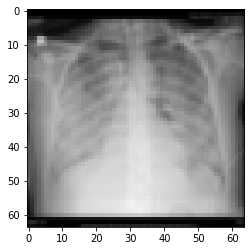

In [24]:
def show(img,label):
  print("label-->",dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

show(*dataset[144])

In [25]:
# Splitting the data into train and validation set
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  # Here indices are randomly permuted 
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
val_per=0.5
train_indices,validation_indices=split_train_val(len(dataset),val_per,randomness)
print(validation_indices[:5])

[  10 1146 2656 1276 1530]


In [27]:
# Subset random sampler takes the indices to pick the data
# dataloader loads with the main dataset, with batch size and the sampler object
batch_size=16
# Training Part
train_sampler=SubsetRandomSampler(train_indices)
train_ds=DataLoader(dataset,batch_size,sampler=train_sampler)

# Validation Part
val_sampler=SubsetRandomSampler(validation_indices)
val_ds=DataLoader(dataset,batch_size,sampler=val_sampler)

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3)
    self.fc1=nn.Linear(in_features=8*31*31,out_features=32)
    self.out=nn.Linear(in_features=32,out_features=3)

  def forward(self,l):
    l=self.conv1(l)
    l=F.relu(l)
    l=F.max_pool2d(l,kernel_size=2)
    l=l.reshape(-1,8*31*31)
    l=self.fc1(l)
    l=self.out(l)

    return l

In [36]:
Model = ConvNet()

In [37]:
print(Model)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7688, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
)


In [38]:
def default_device():
    
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    else:
        return torch.device("cpu")

device=default_device()

In [39]:
Model.to(device)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=7688, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
)

In [41]:
# Define loss and optimizer
import torch.optim as optim
loss_type = nn.CrossEntropyLoss()
# Adam optimizer is the combination of momentum with RMSprop and is more powerful
optimizer = optim.Adam(Model.parameters(), lr=0.0005)

In [43]:
loss_val=[]
for epoch in range(12):  
# loop over the dataset multiple times
    print("Epoch count-->",epoch)
    running_loss=0.0
    for i, data in enumerate(train_ds):
        
        inputs, labels = data
        # Loading inputs,labels on GPU
        inputs,labels=inputs.to(device),labels.to(device)
        #inputs,labels=inputs,labels
        # zero the parameter gradients
        optimizer.zero_grad()

        # Passing input into the model
        outputs = Model(inputs)
        
        # Caculating loss with crossentropy
        loss = loss_type(outputs, labels)
        
        # calculates the gradient 
        loss.backward()
        
        # update the weights
        optimizer.step()
        
        running_loss=running_loss+loss.item()* inputs.size(0)
        
    loss_val.append(running_loss / len(train_ds))
        
    print(running_loss)
        
plt.plot(loss_val,label="loss")
plt.legend()
print('Finished Training')

Epoch count--> 0


KeyboardInterrupt: 

In [46]:
conda info --envs

# conda environments:
#
base                     /home/banikr2/miniconda3
MRCT36                   /home/banikr2/miniconda3/envs/MRCT36
covid36               *  /home/banikr2/miniconda3/envs/covid36
spleen36                 /home/banikr2/miniconda3/envs/spleen36
                         /usr/local/fsl/fslpython
                         /usr/local/fsl/fslpython/envs/fslpython


Note: you may need to restart the kernel to use updated packages.
